In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [17]:
heatmap_path = "value_prop.png"
num_x_bins = 15
num_y_bins = 50
vmin = -2.0
vmax = 7.0
cmap_name = 'plasma'

In [23]:
# 1. Generate reference colors from Matplotlib
cmap = plt.get_cmap(cmap_name)

# Create a high-resolution array of values to match against
resolution = 1000 
reference_values = np.linspace(vmin, vmax, resolution)
    
    # Normalize values to [0, 1] to feed into the colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Extract RGB values from the colormap and scale to 0-255
# cmap(norm(...)) returns RGBA floats. We slice [:, :3] for RGB and multiply by 255.
reference_colors = (cmap(norm(reference_values))[:, :3] * 255).astype(np.uint8)

# 2. Load the cropped heatmap
hm_img = Image.open(heatmap_path).convert('RGB')
width, height = hm_img.size

block_width = width / num_x_bins
block_height = height / num_y_bins

reconstructed_data = np.zeros((num_y_bins, num_x_bins))

# 3. Iterate through the grid, sample, and match
for row in range(num_y_bins):
    for col in range(num_x_bins):
        # Find center of the block
        sample_x = min(int((col * block_width) + (block_width / 2)), width - 1)
        sample_y = min(int((row * block_height) + (block_height / 2)), height - 1)
        
        # Get pixel color
        block_color = np.array(hm_img.getpixel((sample_x, sample_y)))
        
        # Find the closest color in our generated reference colors (Euclidean distance)
        distances = np.linalg.norm(reference_colors - block_color, axis=1)
        closest_index = np.argmin(distances)
        
        # Assign the matched value
        reconstructed_data[row, col] = reference_values[closest_index]


In [24]:
np.save('early.npy', reconstructed_data)

In [25]:
data = reconstructed_data

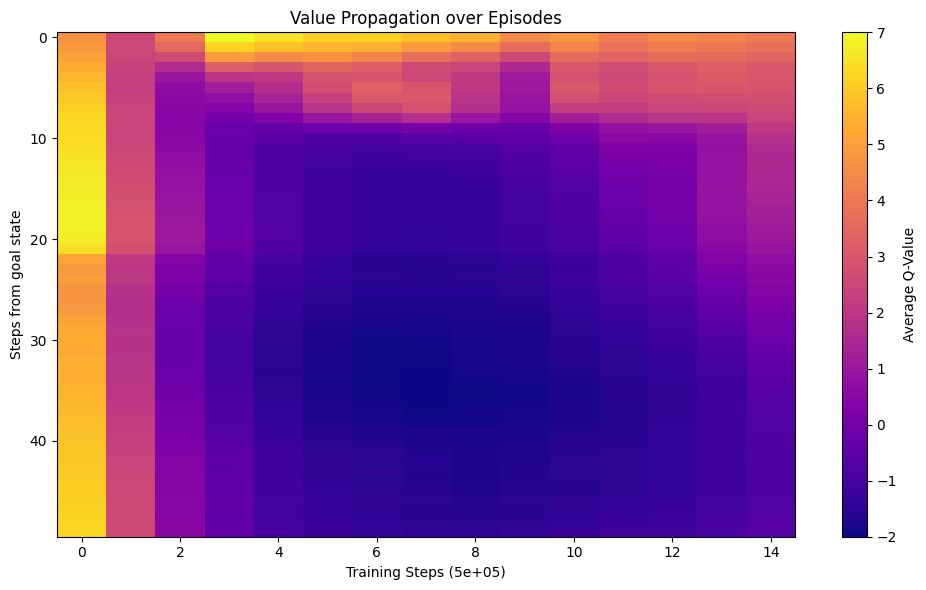

In [26]:
# 2. Set up the figure
# Using a similar aspect ratio to your original screenshot
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Create the heatmap
# aspect='auto' allows the blocks to stretch into rectangles like your original plot
# interpolation='nearest' ensures we see the distinct blocks without blurring
heatmap = ax.imshow(
    data, 
    cmap=cmap_name, 
    vmin=vmin, 
    vmax=vmax, 
    aspect='auto',
    interpolation='nearest' 
)

# 4. Add the colorbar
cbar = fig.colorbar(heatmap)
cbar.set_label('Average Q-Value')

# 5. Add titles and labels (matching your original plot)
ax.set_title('Value Propagation over Episodes')
ax.set_xlabel('Training Steps (5e+05)')
ax.set_ylabel('Steps from goal state')

# 6. Show the plot
plt.tight_layout()
plt.show()